# CNN for Fluo Classification

This tutorial was very helpful, and some code here is taken from it: https://colab.research.google.com/drive/1B5KQvPySqYEa6XicRHdOwgv8fN1BrCgQ#scrollTo=LI6JtYwTt2HM

### Install Dependencies

In [1]:
%matplotlib inline

In [2]:
# !pip install mxnet-cu101
# !pip install gluoncv

Install Conda

In [3]:
!which python
!python --version
!echo $PYTHONPATH

/usr/local/bin/python
Python 3.6.12 :: Anaconda, Inc.
/env/python


In [4]:
# # unset PYTHONPATH because it may interfere with Miniconda
# %env PYTHONPATH=

In [5]:
# %%bash
# MINICONDA_INSTALLER_SCRIPT=Miniconda3-4.5.4-Linux-x86_64.sh
# MINICONDA_PREFIX=/usr/local
# wget https://repo.continuum.io/miniconda/$MINICONDA_INSTALLER_SCRIPT
# chmod +x $MINICONDA_INSTALLER_SCRIPT
# ./$MINICONDA_INSTALLER_SCRIPT -b -f -p $MINICONDA_PREFIX

In [6]:
# !which conda # should return /usr/local/bin/conda
# !conda --version # should return 4.5.4

# # verify the Python executable isn't impacted
# !which python # still returns /usr/local/bin/python

# # Anaconda has slightly different version of Python
# !python --version # now returns Python 3.6.5 :: Anaconda, Inc.

In [7]:
# # update conda without updating Python to 3.7 or 3.8

# %%bash
# conda install --channel defaults conda python=3.6 --yes
# conda update --channel defaults --all --yes

In [8]:
# !conda --version # now returns 4.9.1
# !python --version # now returns Python 3.6.12 :: Anaconda, Inc.

In [9]:
# # Append to sys.path... add directory where Conda will isntall packages to list of directories Python searches through
# import sys
# # print(sys.path)
# # !ls /usr/local/lib/python3.6/dist-packages

# # All packages installed with Conda will go into this directory, which we add to path below:
# conda_pack_dir = "/usr/local/lib/python3.6/site-packages"
# if conda_pack_dir not in sys.path:
#     _ = (sys.path.append(cond_pack_dir))
# print(sys.path)

Install Pytorch (Not actually necessary because colab comes wth Torch)

In [10]:
# !conda install pytorch torchvision torchaudio cudatoolkit=10.2 -c pytorch --yes

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

print("Pytorch version: ", torch.__version__)

Pytorch version:  1.6.0+cu101


In [12]:
import pandas as pd
import numpy as np
import os, time, shutil
import matplotlib.pyplot as plt
from PIL import Image

### Mount Google Drive

In [13]:
import os
from google.colab import files, drive   

# mount the google drive to my Colab session
drive.mount('/content/gdrive')
# use the google drive in my Colab session
home_path = '/content/gdrive/My Drive/cs101'
print(os.listdir(home_path))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
['video_fluo_data', 'video_bf_data', 'processed', 'video_data_time_info_CS101.xlsx', 'ResNet50_v2-finetune-data_aug-order-random-dataaug.params', 'CS 101 Weekly Notes.gslides']


### Get Data

In [14]:
# Fixing the random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Available high quality data
embryo_inds = [1, 3, 12, 13, 16, 18, 19, 24, 39, 40, 42, 45, 46, 47, 49, 50, 52, 53]

# Load info about videos
video_time_info = pd.read_excel(f'{home_path}/video_data_time_info_CS101.xlsx', index_col=0, header=0, na_values=['NaN','NAN'], usecols=['usable_index', 'first_pol_time', 't_num'])  
video_time_info.dropna(inplace=True, subset=['first_pol_time'])
print(video_time_info.loc[embryo_inds])

# Directory of the processed *.npy files
processed_path = f'{home_path}/processed'
polar_processed_path = f'{processed_path}/polarization'

p = np.random.permutation(len(embryo_inds))
p_embryo = [embryo_inds[i] for i in p]
t_num = list(video_time_info.loc[embryo_inds, 't_num'])
t_num_random = list(video_time_info.loc[p_embryo, 't_num'])

instance_cum_random = np.cumsum(t_num_random)
test_split_point = instance_cum_random[-1]*0.83
temp = abs(instance_cum_random-test_split_point)
test_idx = np.argmin(temp)

val_split_point = instance_cum_random[-1]*0.7
temp = abs(instance_cum_random-val_split_point)
val_idx = np.argmin(temp)


train_embryos = p_embryo[:val_idx]
val_embryos = p_embryo[val_idx:test_idx]
test_embryos = p_embryo[test_idx:]
print(train_embryos)
print(val_embryos)
print(test_embryos)

data_path = f'{processed_path}/fluo_data/middle'
pol_path = f'{processed_path}/polarization'
train_path = os.path.join(data_path, 'train')
val_path = os.path.join(data_path, 'val')
test_path = os.path.join(data_path, 'test')

              first_pol_time  t_num
usable_index                       
1                       17.0   21.0
3                       12.0   21.0
12                      11.0  143.0
13                      12.0  143.0
16                      30.0  143.0
18                      27.0  143.0
19                      32.0  143.0
24                      20.0   21.0
39                      12.0   21.0
40                       8.0   21.0
42                      16.0   21.0
45                      19.0   21.0
46                      19.0   21.0
47                      17.0   21.0
49                      21.0   21.0
50                      21.0   21.0
52                      13.0   21.0
53                      20.0   21.0
[1, 3, 39, 18, 13, 47, 52, 50, 45, 12, 40, 53]
[16, 46, 24]
[42, 49, 19]


### Save NP Data as PNG for Training

In [15]:
# Actually create the images

def within_window(embryo_idx, t, window):
    '''
    embryo_idx: index of current embryo (value from 'usable_index' col)
    t: timestep of current
    window: number of t steps from first polarized index to ignore
    '''
    first_pol_idx = video_time_info.loc[embryo_idx, 'first_pol_time'] - 1
    return window and abs(first_pol_idx - t) <= window

def save_nps_as_png(embryos, save_path, window=None):
    '''
    embryos: subset of p_embryo... train, val, test
    save_path: path to save png to... data_path + {'train', 'val', 'test'}
    window: number of t steps from first polarized index to ignore
    '''
    for i in range(len(embryos)):
        embryo_idx = embryos[i]
        embryo_path = f'{data_path}/embryo_{embryo_idx}.npy'
        embryo_pol_path = f'{pol_path}/embryo_{embryo_idx}.npy'
        embryo = np.load(embryo_path)
        embryo_pol = np.squeeze(np.load(embryo_pol_path)).astype(int)
        embryo = embryo.astype(np.float64) / np.max(embryo) # normalize the data to 0 - 1
        embryo = 255 * embryo # Now scale by 255
        embryo = embryo.astype(np.uint8)
        print(embryo_idx, np.shape(embryo)[2])
        for t in range(np.shape(embryo)[2]):
            if within_window(embryo_idx, t, window):
                print(f'skipping embryo {embryo_idx} step {t}')
                continue
            pol = embryo_pol[t]
            img = Image.fromarray(embryo[:,:,t], 'L')
            img_path = f'{save_path}/{pol}/embryo_{embryo_idx}_{t}.png'
            img.save(img_path)


if not os.path.exists(train_path):
    save_nps_as_png(train_embryos, train_path, window=None)
if not os.path.exists(val_path):
    save_nps_as_png(val_embryos, val_path, window=None)
if not os.path.exists(test_path):
    save_nps_as_png(test_embryos, test_path, window=None)

### Set Hyperparameters

In [16]:
n_classes = 2

# # fake params... not actually used in the training loop (the real hyperparameters are instantiated then)
# epochs = 15
# lr = 0.001
# momentum = 0.9
# wd = 0.0001

per_device_batch_size = 20

lr_factor = 0.75
lr_steps = [10, 20, 30, np.inf]

num_workers = 1
num_gpus = 1
gpus = [i for i in range(num_gpus)]

device = torch.device(gpus[0]) if num_gpus > 0 else [torch.device('cpu')]

batch_size = per_device_batch_size * max(num_gpus, 1)
print(device)

cuda:0


Things to keep in mind:

1. ``epochs = 5`` is just for this tutorial with the tiny dataset. please change it to a larger number in your experiments, for instance 40.
2. ``per_device_batch_size`` is also set to a small number. In your experiments you can try larger number like 64.
3. remember to tune ``num_gpus`` and ``num_workers`` according to your machine.
4. A pre-trained model is already in a pretty good status. So we can start with a small ``lr``.

### Data Augmentation

In transfer learning, data augmentation can also help.
We use the following augmentation in training:

2. Randomly crop the image and resize it to 224x224
3. Randomly flip the image horizontally
4. Randomly jitter color and add noise
5. Transpose the data from height*width*num_channels to num_channels*height*width, and map values from [0, 255] to [0, 1]
6. Normalize with the mean and standard deviation from the ImageNet dataset.




In [17]:
## Legacy mxnet transforms
# transform_train = transforms.Compose([
#     transforms.Resize(600, keep_ratio=True),
#     transforms.CenterCrop(512),

#     transforms.RandomFlipLeftRight(), # Randomly flip the image horizontally
#     transforms.RandomFlipTopBottom(),
#     transforms.RandomLighting(0.1), # Add AlexNet-style PCA-based noise to an image
#     transforms.RandomContrast(0.1),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

# transform_test = transforms.Compose([
#     transforms.Resize(600, keep_ratio=True),
#     transforms.CenterCrop(512),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

# an example Torch transform:

# transform = transforms.Compose([
#     transforms.Resize([224,224]), # Resizing the image as the VGG only take 224 x 244 as input size
#     transforms.RandomHorizontalFlip(), # Flip the data horizontally
#     #TODO if it is needed, add the random crop
#     transforms.ToTensor(),
#     transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
# ])

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

### Data Loaders

First we define a subset of the ataset so it is faster to train

In [18]:
from torch.utils.data.sampler import SubsetRandomSampler

n_training_samples = 20 # Max: 50 000 - n_val_samples
n_val_samples = 5
n_test_samples = 5

train_sampler = SubsetRandomSampler(np.arange(n_training_samples, dtype=np.int64))
val_sampler = SubsetRandomSampler(np.arange(n_training_samples, n_training_samples + n_val_samples, dtype=np.int64))
test_sampler = SubsetRandomSampler(np.arange(n_test_samples, dtype=np.int64))
# (In the last case, indexes do not need to account for training ones because the train=False parameter in datasets.CIFAR will select from the test set)

With the data augmentation functions, we can define our data loaders:



In [19]:
# filelist = [f for f in os.listdir(train_path) if os.path.isfile(os.path.join(train_path, f))]
# print(filelist)

# TODO: Shuffle file list

# def check_png(filename):
#   if filename.lower().endswith('.png')
#       return True
#   return False

def check_image(path):
    try:
        im = Image.open(path)
        return True
    except:
        return False

train_data = torchvision.datasets.ImageFolder(root=train_path, transform=transform, target_transform=None, is_valid_file=check_image)
val_data = torchvision.datasets.ImageFolder(root=val_path, transform=transform, target_transform=None, is_valid_file=check_image)
test_data = torchvision.datasets.ImageFolder(root=test_path, transform=transform, target_transform=None, is_valid_file=check_image)

print("Train data: ", train_data)
print("Validation data: ", val_data)
print("Test data: ", test_data)

# Define data loaders
# train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, sampler=None, pin_memory=False, drop_last=False)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, sampler=None, num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True, sampler=None, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, sampler=None, num_workers=num_workers, drop_last=True)

classes = ('unpolarized', 'polarized')

Train data:  Dataset ImageFolder
    Number of datapoints: 618
    Root location: /content/gdrive/My Drive/cs101/processed/fluo_data/middle/train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Validation data:  Dataset ImageFolder
    Number of datapoints: 185
    Root location: /content/gdrive/My Drive/cs101/processed/fluo_data/middle/val
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Test data:  Dataset ImageFolder
    Number of datapoints: 185
    Root location: /content/gdrive/My Drive/cs101/processed/fluo_data/middle/test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


Visualize some training images

 polarized  polarized  polarized  polarized  polarized  polarized  polarized  polarized  polarized unpolarized  polarized  polarized  polarized  polarized  polarized  polarized  polarized  polarized  polarized  polarized


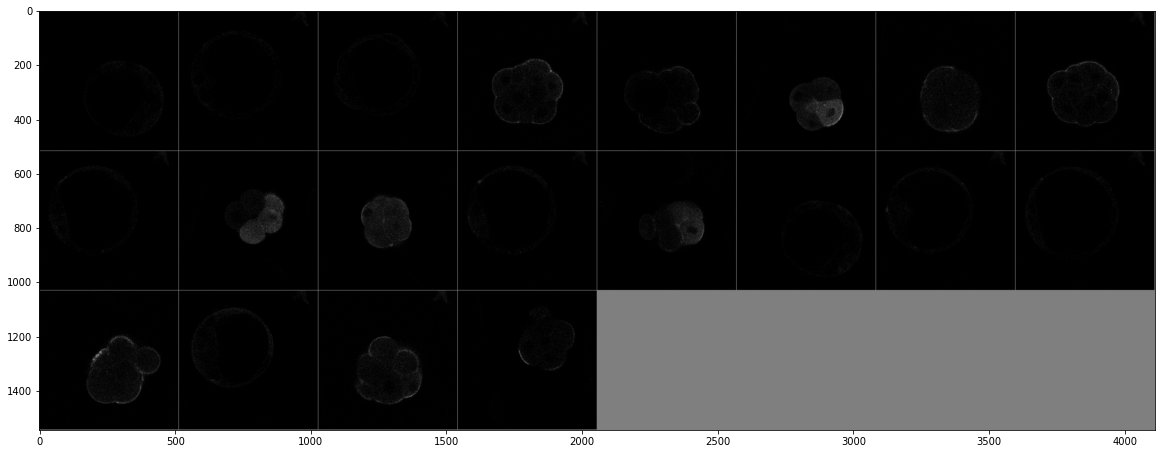

In [20]:
# get some random training images
dataiter = iter(train_loader)
# next(dataiter)

images, labels = dataiter.next()

# show images

# functions to show an image
def imshow(img):
    """
    :param img: (PyTorch Tensor)
    """
    # unnormalize
    img = img / 2 + 0.5     
    # Convert tensor to numpy array
    npimg = img.numpy()
    plt.figure(figsize = (20,8))
    # Color channel first -> color channel last
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

  
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('{:>10}'.format(classes[labels[j]]) for j in range(batch_size)))

In [21]:
images[0].shape

torch.Size([3, 512, 512])


Note that only ``train_data`` uses ``transform_train``, while
``val_data`` and ``test_data`` use ``transform_test`` to produce deterministic
results for evaluation.

### Define Model

Simple CNN for now

In [22]:
class SimpleConvolutionalNetwork(nn.Module):
    def __init__(self):
        super(SimpleConvolutionalNetwork, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 20, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(20, 50, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # cf comments in forward() to have step by step comments on shape progression
        self.fc1 = nn.Linear(50 * 128 * 128, 64)
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        """
        Forward pass,
        x shape is (batch_size, 3, 512, 512)
        (color channel first)
        in the comments, we omit the batch_size in the shape
        """
        # print(x.shape)

        # shape : 3x512x512 -> 20x512x512
        x = F.relu(self.conv1(x))
        # print(x.shape)

        # 20x512x512 -> 20x256x256
        x = self.pool1(x)
        # print(x.shape)

        # 20x256x256 -> 50x256x256
        x = F.relu(self.conv2(x))
        # print(x.shape)

        # 50x256x256 -> 50x128x128
        x = self.pool2(x)
        # print(x.shape)

        # 50x128x128 -> 819200
        x = x.view(-1, 50 * 128 * 128)
        # print(x.shape)

        # 819200 -> 64
        x = F.relu(self.fc1(x))
        # print(x.shape)

        # 64 -> 2
        # The softmax non-linearity is applied later (cf createLossAndOptimizer() fn)
        x = self.fc2(x)
        # print(x.shape)

        return x

In [23]:
class LinearClassifier(nn.Module):
    """
    Linear Classifier
    """
    def __init__(self):
        super(LinearClassifier, self).__init__()
        self.linear = nn.Linear(32 * 32 * 3, 10)

    def forward(self, x):
        # Flatten input 3x32x32 -> 3072
        x = x.view(x.size(0), -1)
        return self.linear(x)

### Initialize Optimizer and Some Helpers

In [24]:
import torch.optim as optim

def createLossAndOptimizer(net, learning_rate=0.01):
    # it combines softmax with negative log likelihood loss
    criterion = nn.CrossEntropyLoss()  
    #optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    return criterion, optimizer

In [25]:
# duplicate from before, but maybe it's useful to be able to change the batch size dynamically during training...? mini-batches?

def get_train_loader(batch_size):
    return torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, sampler=None,
                                              num_workers=num_workers)

# Use larger batch size for validation to speed up computation
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True, sampler=None,
                                          num_workers=num_workers)

### Training Loop

Following is the main training loop. It is the same as the loop in
`CIFAR10 <dive_deep_cifar10.html>`__
and ImageNet.

In [26]:
def train(net, batch_size, n_epochs, learning_rate):
    """
    Train a neural network and print statistics of the training
    
    :param net: (PyTorch Neural Network)
    :param batch_size: (int)
    :param n_epochs: (int)  Number of iterations on the training set
    :param learning_rate: (float) learning rate used by the optimizer
    """
    print("===== HYPERPARAMETERS =====")
    print("batch_size=", batch_size)
    print("n_epochs=", n_epochs)
    print("learning_rate=", learning_rate)
    print("=" * 30)
    
    train_loader = get_train_loader(batch_size)
    n_minibatches = len(train_loader)
    print("number of minibaches: ", n_minibatches)

    criterion, optimizer = createLossAndOptimizer(net, learning_rate)
    # Init variables used for plotting the loss
    train_history = []
    val_history = []
    train_history_acc = []
    val_history_acc = []

    training_start_time = time.time()
    best_error = np.inf
    best_model_path = "best_model.pth"

    # mutli-gpu
    if gpus is not None and len(gpus) > 1:
        print('multi-gpu ', gpus)
        net = torch.nn.DataParallel(net, device_ids=gpus)  # model becomes `torch.nn.DataParallel` w/ model.module being the orignal `torch.nn.Module`
        net = net.to(device)

    # Move model to gpu if possible
    else:
        net = net.to(device)

    for epoch in range(n_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        print_every = n_minibatches // 10
        start_time = time.time()
        total_train_loss = 0
        n_correct_train = 0
        
        for i, (inputs, labels) in enumerate(train_loader):

            # Move tensors to correct device
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # print statistics
            running_loss += loss.item()
            total_train_loss += loss.item()

            # print every 10th of epoch
            if (i + 1) % (print_every + 1) == 0:    
                print("Epoch {}, {:d}% \t train_loss: {:.2f} took: {:.2f}s".format(
                      epoch + 1, int(100 * (i + 1) / n_minibatches), running_loss / print_every,
                      time.time() - start_time))
                running_loss = 0.0
                start_time = time.time()

            _, predictions = torch.max(outputs.data, 1)
            n_correct_train += (predictions == labels).float().sum()

        
        train_accuracy = 100 * n_correct_train / len(train_loader)
        train_history_acc.append(train_accuracy)
        train_history.append(total_train_loss / len(train_loader))

        total_val_loss = 0
        n_correct_val = 0
        # Do a pass on the validation set
        # We don't need to compute gradient,
        # we save memory and computation using torch.no_grad()
        with torch.no_grad():
          for inputs, labels in val_loader:
              # Move tensors to correct device
              inputs, labels = inputs.to(device), labels.to(device)
              # Forward pass
              outputs = net(inputs)

              val_loss = criterion(outputs, labels)
              total_val_loss += val_loss.item()

              _, predictions = torch.max(outputs.data, 1)
              n_correct_val += (predictions == labels).float().sum()

        val_accuracy = 100 * n_correct_val / len(val_loader)
        val_history_acc.append(val_accuracy)    
        val_history.append(total_val_loss / len(val_loader))
        # Save model that performs best on validation set
        if total_val_loss < best_error:
            best_error = total_val_loss
            torch.save(net.state_dict(), best_model_path)

        print("Validation loss = {:.2f}".format(total_val_loss / len(val_loader)))

    print("Training Finished, took {:.2f}s".format(time.time() - training_start_time))
    
    # Load best model
    net.load_state_dict(torch.load(best_model_path))
    
    return train_history, val_history, train_history_acc, val_history_acc

In [27]:
net = SimpleConvolutionalNetwork()

train_history, val_history, train_history_acc, val_history_acc = train(net, batch_size=batch_size, n_epochs=10, learning_rate=0.001)

===== HYPERPARAMETERS =====
batch_size= 20
n_epochs= 10
learning_rate= 0.001
number of minibaches:  31
Epoch 1, 12% 	 train_loss: 49.67 took: 1.22s
Epoch 1, 25% 	 train_loss: 6.46 took: 1.02s
Epoch 1, 38% 	 train_loss: 1.54 took: 1.03s
Epoch 1, 51% 	 train_loss: 0.72 took: 1.03s
Epoch 1, 64% 	 train_loss: 0.79 took: 1.04s
Epoch 1, 77% 	 train_loss: 0.82 took: 1.04s
Epoch 1, 90% 	 train_loss: 0.80 took: 1.01s
Validation loss = 0.51
Epoch 2, 12% 	 train_loss: 0.78 took: 1.33s
Epoch 2, 25% 	 train_loss: 0.76 took: 1.03s
Epoch 2, 38% 	 train_loss: 0.63 took: 1.06s
Epoch 2, 51% 	 train_loss: 0.62 took: 1.02s
Epoch 2, 64% 	 train_loss: 0.58 took: 1.03s
Epoch 2, 77% 	 train_loss: 0.46 took: 1.03s
Epoch 2, 90% 	 train_loss: 0.45 took: 1.04s
Validation loss = 0.21
Epoch 3, 12% 	 train_loss: 0.51 took: 1.32s
Epoch 3, 25% 	 train_loss: 0.45 took: 1.04s
Epoch 3, 38% 	 train_loss: 0.49 took: 1.05s
Epoch 3, 51% 	 train_loss: 0.39 took: 1.04s
Epoch 3, 64% 	 train_loss: 0.46 took: 1.01s
Epoch 3, 77% 	

Evaluate the accuracy

In [28]:
def dataset_accuracy(net, data_loader, name=""):
    net = net.to(device)
    correct = 0
    total = 0
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
    accuracy = 100 * float(correct) / total
    print('Accuracy of the network on the {} {} images: {:.2f} %'.format(total, name, accuracy))

def train_set_accuracy(net):
    dataset_accuracy(net, train_loader, "train")

def val_set_accuracy(net):
    dataset_accuracy(net, val_loader, "validation")  
    
def test_set_accuracy(net):
    dataset_accuracy(net, test_loader, "test")

def compute_accuracy(net):
    train_set_accuracy(net)
    val_set_accuracy(net)
    test_set_accuracy(net)
    
print("Computing accuracy...")
compute_accuracy(net)

Computing accuracy...
Accuracy of the network on the 618 train images: 92.07 %
Accuracy of the network on the 185 validation images: 95.14 %
Accuracy of the network on the 180 test images: 80.56 %


### Plot results (these need to be refactored)


In [29]:
def plot_losses(train_history, val_history):
    x = np.arange(1, len(train_history) + 1)

    plt.figure(figsize=(8, 6), dpi=100)
    plt.plot(x, train_history, '-r', label="Training loss", linewidth=2)
    plt.plot(x, val_history, '-b', label="Validation loss", linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title("Training and Validation Loss History")
    plt.show()

def plot_accuracy(train_accs, val_accs):
    x = np.arange(1, len(train_history) + 1)

    plt.figure(figsize=(8, 6), dpi=100)
    plt.plot(x, train_accs, '-r', label="Training accuracy", linewidth=2)
    plt.plot(x, val_accs, '-b', label="Validation accuracy", linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper right')
    plt.title("Training and Validation Accuracy History")
    plt.show()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    :param cm: (numpy matrix) confusion matrix
    :param classes: [str]
    :param normalize: (bool)
    :param title: (str)
    :param cmap: (matplotlib color map)
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(8, 8), dpi=100)   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [30]:
# plt.figure()
# plt.plot(np.arange(0,epochs,1),train_acc_lst,'r')
# plt.ylabel('Training Accuracy')
# plt.xlabel('Epoch')
# plt.title('CNN Classify Fluo Polarization')
# plt.show()

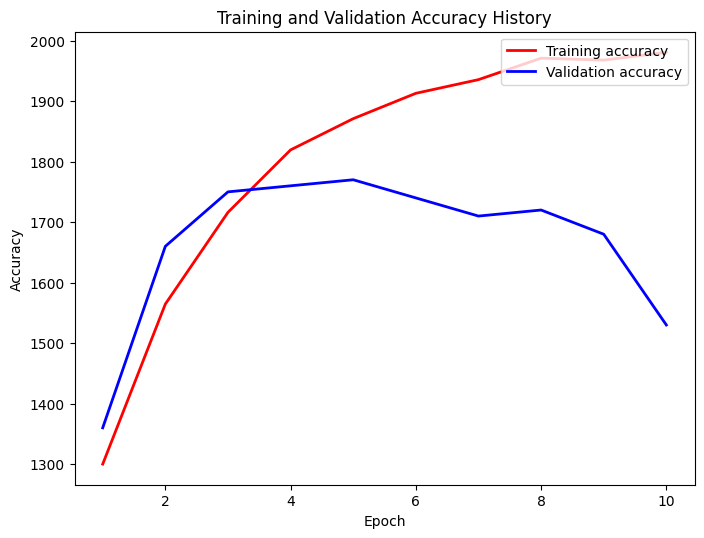

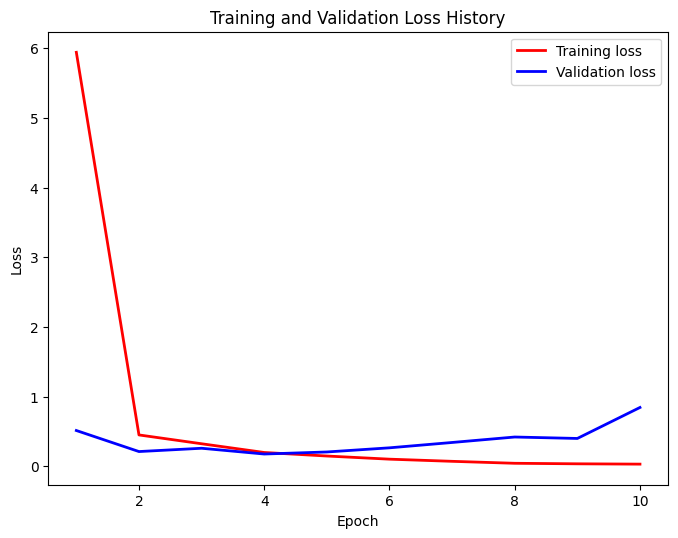

In [31]:
# plt.figure()
# plt.plot(np.arange(0,epochs,1),train_loss_lst,'r')
# plt.ylabel('Training Loss')
# plt.xlabel('Epoch')
# plt.title('CNN Classify Fluo Polarization')
# plt.show()

plot_accuracy(train_history_acc, val_history_acc)
plot_losses(train_history, val_history)

In [32]:
# plt.figure()
# plt.plot(np.arange(0,epochs,1),val_acc_lst,'r')
# plt.ylabel('Validation Accuracy')
# plt.xlabel('Epoch')
# plt.title('CNN Classify Fluo Polarization')
# plt.show()

In [33]:
import itertools

test_batch_size = batch_size

def accuracy_per_class(net):
    net = net.to(device)
    n_classes = 2
    # (real, predicted)
    confusion_matrix = np.zeros((n_classes, n_classes), dtype=np.int64)

    for images, labels in test_loader:
        images, labels = images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        for i in range(test_batch_size):
            confusion_matrix[labels[i], predicted[i]] += 1
            label = labels[i]

    print("{:<10} {:^10}".format("Class", "Accuracy (%)"))
    for i in range(n_classes):
        class_total = confusion_matrix[i, :].sum()
        class_correct = confusion_matrix[i, i]
        percentage_correct = 100.0 * float(class_correct) / class_total
        
        print('{:<10} {:^10.2f}'.format(classes[i], percentage_correct))
    return confusion_matrix

confusion_matrix = accuracy_per_class(net)

Class      Accuracy (%)
unpolarized   46.03   
polarized    98.29   


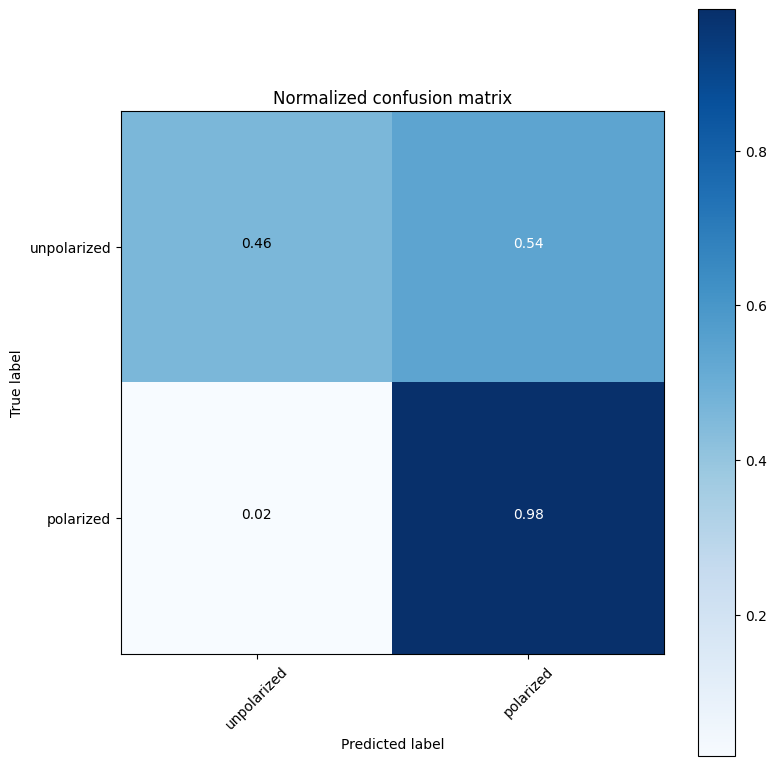

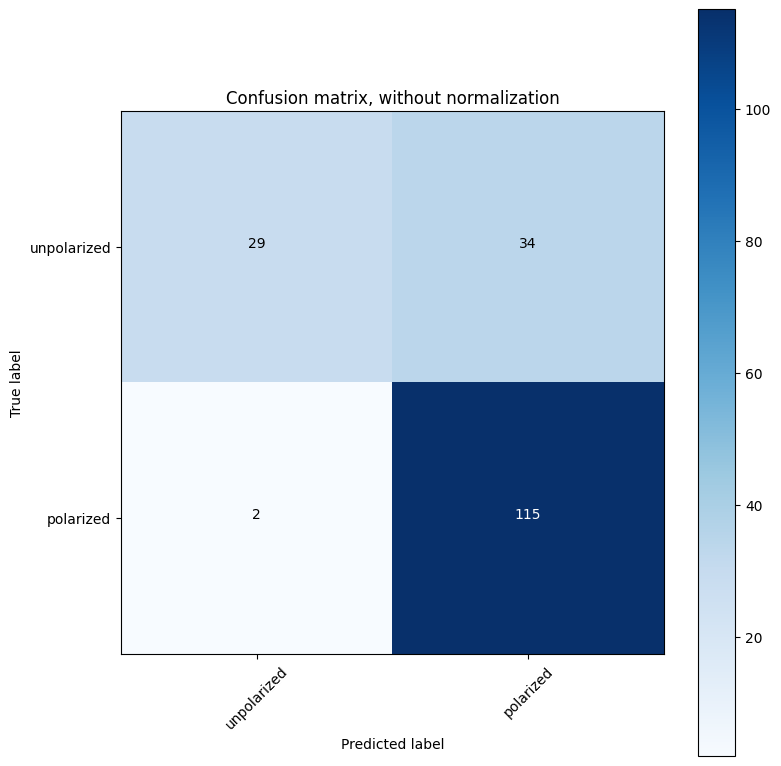

In [34]:
# Plot normalized confusion matrix
plot_confusion_matrix(confusion_matrix, classes, normalize=True,
                      title='Normalized confusion matrix')

# Plot non-normalized confusion matrix
plot_confusion_matrix(confusion_matrix, classes,
                      title='Confusion matrix, without normalization')

In [35]:
print(net)

SimpleConvolutionalNetwork(
  (conv1): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(20, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=819200, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)


In [36]:
!pip install torchsummary

In [37]:
from torchsummary import summary
summary(net, (3,512,512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 20, 512, 512]             560
         MaxPool2d-2         [-1, 20, 256, 256]               0
            Conv2d-3         [-1, 50, 256, 256]           9,050
         MaxPool2d-4         [-1, 50, 128, 128]               0
            Linear-5                   [-1, 64]      52,428,864
            Linear-6                    [-1, 2]             130
Total params: 52,438,604
Trainable params: 52,438,604
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 3.00
Forward/backward pass size (MB): 81.25
Params size (MB): 200.04
Estimated Total Size (MB): 284.29
----------------------------------------------------------------
